# Adaptive Intelligence COM3240

#### Script that returns the learnign curve for each trial

In [331]:
import numpy as np
import scipy.spatial.distance as dist

def Start(N, M):
    return np.array([np.random.randint(N), np.random.randint(M)])   #random start

def homing_nn(n_trials, learning_rate, eps, gamma, max_steps=50, count_min_steps=False, count_actions=False, diagonal=False):

    # Solving homing task with on-policy TD (SARSA)


    ## Definition of the environment
    N = 3                               #height of the gridworld ---> number of rows
    M = 4                              #length of the gridworld ---> number of columns
    N_states = N * M                    #total number of states
    states_matrix = np.eye(N_states)
    if diagonal:
        #                              N  NE   E  SE   S  SW   W  NW
        action_row_change = np.array([-1, -1,  0, +1, +1, +1,  0, -1])
        action_col_change = np.array([ 0, +1, +1, +1,  0, -1, -1, +1])
    else:
        #                              N   E   S   W
        action_row_change = np.array([-1,  0, +1,  0])#number of cell shifted in vertical as a function of the action
        action_col_change = np.array([ 0, +1,  0, -1])#number of cell shifted in horizontal as a function of the action
    N_actions = action_row_change.shape[0]
    End = np.array([1, 1])                                  #terminal state--->reward
    s_end = np.ravel_multi_index(End, dims = (N, M), order = 'F')  #terminal state. Conversion in single index

    ## Parameters of the model
    #gamma = 0.9                        #discounting factor
    #learning_rate = 0.5                #constant step-size parameter (learning rate)
    #eps = 0.0                          #epsilon-greedy SARSA

    ## Rewards
    R = 10                              #only when the robot reaches the charger, sited in End state

    ## Variables
    weights = np.random.rand(N_actions, N_states)
    learning_curve = np.zeros((1 + count_min_steps, n_trials))
    if count_actions:
        pref_actions = []

    ## SARSA

    # Start trials
    for trial in range(n_trials):

        # Initialization
        Start_mat = Start(N, M)
        s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')      #conversion in single index
        
        #Make sure the robot doesn't start on the goal
        while s_start == s_end:
            Start_mat = Start(N, M)
            s_start = np.ravel_multi_index(Start_mat, dims = (N, M), order = 'F')
        state = Start_mat                                                   #set current state
        s_index = s_start      
        step = 0
        
        if count_min_steps:
            if diagonal:
                min_steps = dist.chebyshev(Start_mat, End) #Chebyshev   Distance between start and end
            else:
                min_steps = dist.cityblock(Start_mat, End) #Manhattan Distance between start and end
            learning_curve[1, trial]= min_steps
        # Start steps
        trial_pref_actions = []
        while s_index != s_end and step <= max_steps:
            step += 1
            learning_curve[0, trial]= step

            input_vector = states_matrix[:, s_index].reshape(N_states, 1)         #convert the state into an input vector

            #compute Qvalues. Qvalue = logsig(weights*input). Qvalue is 2x1, one value for each output neuron
            Q = 1 / ( 1 + np.exp( - weights.dot(input_vector)))    #Qvalue is 2x1 implementation of logsig

            #eps-greedy policy implementation
            greedy = (np.random.rand() > eps)               #1--->greedy action 0--->non-greedy action
            if greedy:
                action = np.argmax(Q)                           #pick best action
            else:
                action = np.random.randint(N_actions)           #pick random action
            if count_actions:
                trial_pref_actions += [action]

            state_new = np.array([0, 0])
            #move into a new state
            state_new[0]= state[0] + action_row_change[action]
            state_new[1]= state[1] + action_col_change[action]

            #initialise reward
            r = 0
            
            #put the robot back in grid if it goes out.
            lt_x = state_new[0] < 0
            if lt_x:
                state_new[0]= 0
            gt_x = state_new[0] >= N
            if gt_x:
                state_new[0]= N-1
            lt_y = state_new[1] < 0
            if lt_y:
                state_new[1]= 0
            gt_y = state_new[1] >= M
            if gt_y:
                state_new[1]= M-1
            #give a negative reward
            if lt_x or gt_x or lt_y or gt_y:
                r = -1
            #Diagonal
            if (lt_x or gt_x) and (lt_y or gt_y):
                r = -2
            
            s_index_new = np.ravel_multi_index(state_new, dims = (N, M), order = 'F')  #conversion in a single index

            #if is not the first step
            if step > 1: 
                #update Qvalues
                weights += learning_rate * (r_old + gamma * Q[action] - Q_old) * output_old.dot(input_old.T)

            #store variables for sarsa computation in the next step
            output = np.zeros((N_actions, 1))
            output[action]= 1

            #update variables
            input_old = input_vector
            output_old = output
            Q_old = Q[action]
            r_old = r

            state[0]= state_new[0]
            state[1]= state_new[1]
            s_index = s_index_new

            ## check if state is terminal and update the weights consequently
            if s_index == s_end:
                weights += learning_rate * (R - Q_old) * output_old.dot(input_old.T)
                pass
        if count_actions:
            pref_actions += [trial_pref_actions]

    return (learning_curve, pref_actions) if count_actions else learning_curve


#### Call the function homing_nn


{'N': [12], 'NE': [71], 'E': [2], 'SE': [29], 'S': [14], 'SW': [45], 'W': [129], 'NW': [2]}


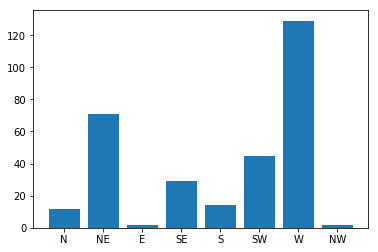

(2, 100)
[[ 12.   4.   4.   3.   3.   6.   4.   3.   3.   5.   4.   4.   5.   2.
    9.   3.   1.   5.   3.  11.   5.   1.   3.   2.   3.   5.   1.   2.
    2.   4.   4.   4.   1.   3.   1.   2.   1.   3.   4.   4.   4.   2.
    4.   4.   4.   2.   3.   2.   3.   4.   3.   1.   2.   1.   4.   1.
    4.   3.   3.   3.   4.   4.   4.   4.   3.   2.   3.   2.   2.   4.
    2.   4.   3.   1.   2.   1.   3.   4.   3.   2.   1.   2.   1.   4.
    2.   1.   1.   3.   3.   2.   4.   3.   2.   2.   1.   1.   2.   2.
    2.   2.]
 [  1.   2.   2.   1.   1.   1.   2.   1.   1.   2.   2.   2.   2.   1.
    1.   1.   1.   1.   1.   1.   2.   1.   1.   1.   1.   2.   1.   1.
    2.   2.   1.   2.   1.   1.   1.   1.   1.   1.   2.   2.   2.   1.
    2.   2.   2.   2.   1.   1.   1.   2.   1.   1.   2.   1.   2.   1.
    2.   1.   1.   1.   2.   2.   2.   2.   1.   1.   1.   2.   1.   2.
    2.   2.   1.   1.   1.   1.   1.   2.   1.   1.   1.   1.   1.   2.
    2.   1.   1.   1.   1.   1.   2.   1. 

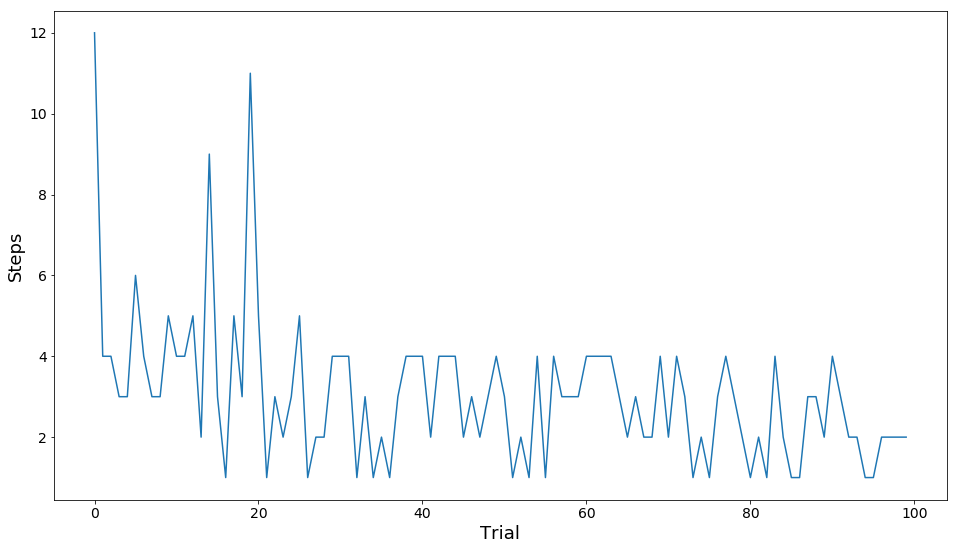

In [332]:
#We will call this procedure one run of the algorithm.
n_trials = 100
learning_rate=0.5                #constant step-size parameter (learning rate)
eps=0.0                          #epsilon-greedy SARSA
gamma=0.9                        #discounting factor
c_min_steps = True
c_actions = True
diag = True
import matplotlib.pyplot as plt
l_curve=homing_nn(n_trials,learning_rate,eps,gamma, count_min_steps=c_min_steps, count_actions=c_actions, diagonal=diag)
if c_actions:
    if diag:
        actions_dict = dict(zip(['N',
                                 'NE',
                                 'E',
                                 'SE', 
                                 'S', 
                                 'SW', 
                                 'W', 
                                 'NW'],
                                [[],[],[],[],[],[],[],[]]))
    else:
        actions_dict = dict(zip(['North','East','South','West'],[[],[],[],[]]))
    flat_pref_actions = [action_n for sublist in l_curve[1] for action_n in sublist]
    l_curve = l_curve[0]
    if diag:
        actions_dict['N'] +=[flat_pref_actions.count(0)]
        actions_dict['NE'] +=[flat_pref_actions.count(1)]
        actions_dict['E']  +=[flat_pref_actions.count(2)]
        actions_dict['SE'] +=[flat_pref_actions.count(3)]
        actions_dict['S'] +=[flat_pref_actions.count(4)]
        actions_dict['SW'] +=[flat_pref_actions.count(5)]
        actions_dict['W']  +=[flat_pref_actions.count(6)]
        actions_dict['NW'] +=[flat_pref_actions.count(7)]
    else:
        actions_dict['North'] +=[flat_pref_actions.count(0)]
        actions_dict['East']  +=[flat_pref_actions.count(1)]
        actions_dict['South'] +=[flat_pref_actions.count(2)]
        actions_dict['West']  +=[flat_pref_actions.count(3)]
    print(actions_dict)
    plt.bar(range(len(actions_dict)), [np.mean(l) for l in actions_dict.values()], align='center')
    plt.xticks(range(len(actions_dict)), list(actions_dict.keys()))
    plt.show()
    
print(l_curve.shape)
print(l_curve)
fontsize=18
plt.figure(figsize=(16, 9))
plt.plot(l_curve[0].T)
plt.xlabel('Trial',fontsize=fontsize)
plt.ylabel('Steps',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [303]:
#produce a curve that is the average of the learning curves of the individual runs.
def manyruns(n_trials,learning_rate,eps,gamma, max_steps=50, count_min_steps=False, count_actions=False, diagonal=False):
    runs=100
    total_steps=np.zeros((runs,n_trials))
    if count_actions:
        if diagonal:
            actions_dict = dict(zip(['N',
                                     'NE',
                                     'E',
                                     'SE', 
                                     'S', 
                                     'SW', 
                                     'W', 
                                     'NW'],
                                    [[],[],[],[],[],[],[],[]]))
        else:
            actions_dict = dict(zip(['North','East','South','West'],[[],[],[],[]]))
    for j in range(runs):
        l_curve=homing_nn(n_trials,learning_rate,eps,gamma,max_steps,count_min_steps,count_actions, diagonal)
        if count_actions:
            flat_pref_actions = [action_n for sublist in l_curve[1] for action_n in sublist]
            l_curve = l_curve[0]
            if diagonal:
                actions_dict['N'] +=[flat_pref_actions.count(0)]
                actions_dict['NE'] +=[flat_pref_actions.count(1)]
                actions_dict['E']  +=[flat_pref_actions.count(2)]
                actions_dict['SE'] +=[flat_pref_actions.count(3)]
                actions_dict['S'] +=[flat_pref_actions.count(4)]
                actions_dict['SW'] +=[flat_pref_actions.count(5)]
                actions_dict['W']  +=[flat_pref_actions.count(6)]
                actions_dict['NW'] +=[flat_pref_actions.count(7)]
            else:
                actions_dict['North'] +=[flat_pref_actions.count(0)]
                actions_dict['East']  +=[flat_pref_actions.count(1)]
                actions_dict['South'] +=[flat_pref_actions.count(2)]
                actions_dict['West']  +=[flat_pref_actions.count(3)]
        total_steps[j,:]=l_curve[0].T
    
    plt.figure(figsize=(16, 9))
    means=np.mean(total_steps, axis=0)
    errors=2*np.std(total_steps, axis=0)/np.sqrt(runs)
    plt.errorbar(np.arange(n_trials), means, errors, 0, elinewidth=2, capsize=4, alpha=0.8)
    plt.xlabel('Trial',fontsize=fontsize)
    plt.ylabel('Average Steps',fontsize=fontsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()
    if count_actions:
        #plt.bar(range(len(actions_dict)), [np.mean(l) for l in actions_dict.values()], align='center')
        actions_errors=[2*np.std(l, axis=0)/np.sqrt(runs) for l in actions_dict.values()]
        plt.bar(range(len(actions_dict)), [np.mean(l) for l in actions_dict.values()], yerr=actions_errors, align='center', ecolor='black', capsize=10)
        plt.xticks(range(len(actions_dict)), list(actions_dict.keys()))
        plt.show()

In [ ]:
manyruns(n_trials,learning_rate,eps,gamma,count_actions=True, diagonal=True)

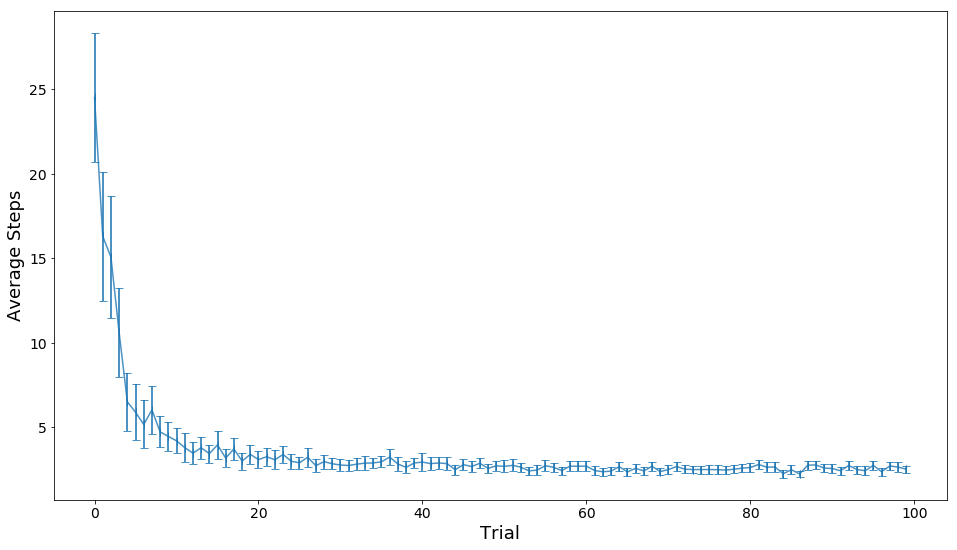

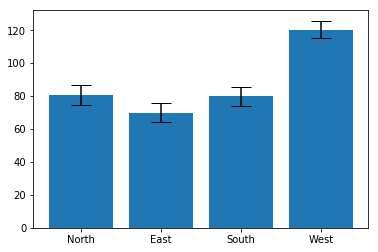

In [222]:
manyruns(n_trials,learning_rate,eps,gamma,count_actions=True)

In [223]:
""" Minimise total difference between the actual number of steps and the total number of steps subject to learning_rate, eps,
    and gamma all between 0 and 1 inclusive."""
from scipy.optimize import minimize
from tabulate import tabulate
def to_optimise(aeg, diagonal=False):
    lc = homing_nn(n_trials,
                   aeg[0],
                   aeg[1],
                   aeg[2],
                   count_min_steps=True, diagonal=diagonal)
    equal = sum(i!=j for i,j in lc.T)
    return equal

In [298]:
cons = ({'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]},
        {'type': 'ineq', 'fun': lambda x:  1-x[0]},
        {'type': 'ineq', 'fun': lambda x:  1-x[1]},
        {'type': 'ineq', 'fun': lambda x:  1-x[2]})

opt_runs = 25
params_dict = dict(zip(['alpha', 'epsilon', 'gamma'],[[],[],[]]))
params = [learning_rate, eps,gamma] #Initial Guess
threshold = 10
max_iter = 25
for j in range(opt_runs):
    print(j)
    inequalities = 100
    params_arr=[]
    i = 0
    while (inequalities > threshold):
        i += 1
        res = minimize(to_optimise, params, method='COBYLA', constraints=cons, tol=1e-6)
        if res.fun < inequalities:
            inequalities = res.fun
            params = res.x
        if i ==max_iter:
            print("Maximum iterations reached")
            i -= 1
            break
        params_arr += [params]
    foo_bar = len(params_arr)
    params_arr = np.pad(params_arr,  [(0, max_iter-i), (0, 0)], 'edge')
    print(str(foo_bar), str(i), str(params_arr.shape))
    params_dict['alpha'] +=[params_arr.T[0]]
    params_dict['epsilon'] += [params_arr.T[1]]
    params_dict['gamma'] += [params_arr.T[2]]

0
3 3 (25, 3)
1
2 2 (25, 3)
2
1 1 (25, 3)
3
2 2 (25, 3)
4
1 1 (25, 3)
5
1 1 (25, 3)
6
1 1 (25, 3)
7
4 4 (25, 3)
8
1 1 (25, 3)
9
6 6 (25, 3)
10
2 2 (25, 3)
11
6 6 (25, 3)
12
2 2 (25, 3)
13
3 3 (25, 3)
14
1 1 (25, 3)
15
1 1 (25, 3)
16
2 2 (25, 3)
17
1 1 (25, 3)
18
7 7 (25, 3)
19
1 1 (25, 3)
20
1 1 (25, 3)
21
1 1 (25, 3)
22
2 2 (25, 3)
23
2 2 (25, 3)
24
4 4 (25, 3)


In [224]:
cons = ({'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]},
        {'type': 'ineq', 'fun': lambda x:  1-x[0]},
        {'type': 'ineq', 'fun': lambda x:  1-x[1]},
        {'type': 'ineq', 'fun': lambda x:  1-x[2]})

opt_runs = 25
params_dict = dict(zip(['alpha', 'epsilon', 'gamma'],[[],[],[]]))
params = [learning_rate, eps,gamma] #Initial Guess
threshold = 10
max_iter = 25
for j in range(opt_runs):
    print(j)
    inequalities = 100
    params_arr=[]
    i = 0
    while (inequalities > threshold):
        i += 1
        res = minimize(to_optimise, params, method='COBYLA', constraints=cons, tol=1e-6)
        if res.fun < inequalities:
            inequalities = res.fun
            params = res.x
        if i ==max_iter:
            print("Maximum iterations reached")
            i -= 1
            break
        params_arr += [params]
    params_arr = np.pad(params_arr,  [(0, max_iter-i), (0, 0)], 'edge')
    params_dict['alpha'] +=[params_arr.T[0]]
    params_dict['epsilon'] += [params_arr.T[1]]
    params_dict['gamma'] += [params_arr.T[2]]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


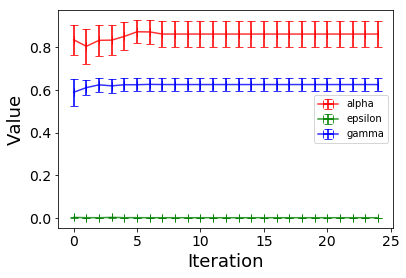

In [225]:
def opt_means(param_name):
    return [np.mean(l) for l in np.array(params_dict[param_name]).T]
def opt_sems(param_name):
    return [2*np.std(l, axis=0)/np.sqrt(opt_runs) for l in np.array(params_dict[param_name]).T]
alpha_plot=plt.errorbar(np.arange(opt_runs), opt_means('alpha'), opt_sems('alpha'), 0, elinewidth=2, capsize=4, alpha=0.8, color='r',label='alpha')
epsilon_plot=plt.errorbar(np.arange(opt_runs), opt_means('epsilon'), opt_sems('epsilon'), 0, elinewidth=2, capsize=4, alpha=0.8, color='g',label='epsilon')
gamma_plot=plt.errorbar(np.arange(opt_runs), opt_means('gamma'), opt_sems('gamma'), 0, elinewidth=2, capsize=4, alpha=0.8, color='b',label='gamma')
plt.legend(handles=[alpha_plot, epsilon_plot, gamma_plot])
plt.xlabel('Iteration',fontsize=fontsize)
plt.ylabel('Value',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


\overline{\alpha} &= 0.862582 \pm 0.061709\\
\overline{\epsilon} &= 0.000127 \pm 0.000131\\
\overline{\gamma} &= 0.625481 \pm 0.030302\\


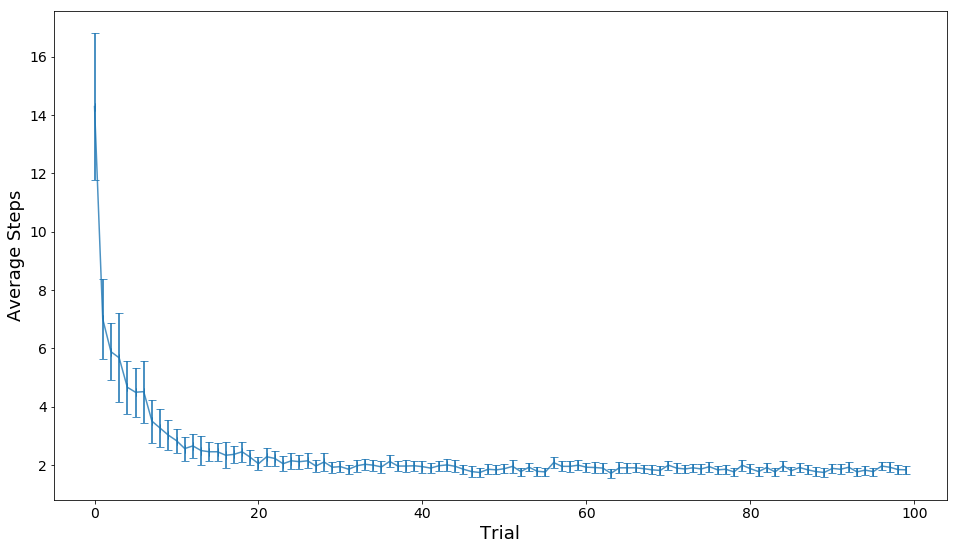

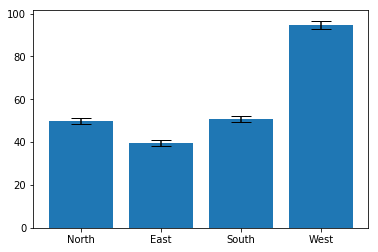

In [226]:
final_params = []
for k in params_dict.keys():
    foo_bar = np.round(opt_means(k)[-1],6)
    foo_sem = np.round(opt_sems(k)[-1],6)
    final_params += [foo_bar]
    print("\overline{\\" + k + "}", '&=', str(foo_bar),'\pm',str(foo_sem)+"\\\\")
manyruns(n_trials, *tuple(final_params),count_actions=True)

In [266]:
#1st column
print(np.ravel_multi_index([0,0], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([1,0], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([2,0], dims = (3, 4), order = 'F'))
#2nd column
print(np.ravel_multi_index([0,1], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([1,1], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([2,1], dims = (3, 4), order = 'F'))
#3rd column
print(np.ravel_multi_index([0,2], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([1,2], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([2,2], dims = (3, 4), order = 'F'))
#4th column
print(np.ravel_multi_index([0,3], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([1,3], dims = (3, 4), order = 'F'))
print(np.ravel_multi_index([2,3], dims = (3, 4), order = 'F'))

0
1
2
3
4
5
6
7
8
9
10
11


In [307]:
final_params=[0.862582,0.000127,0.625481]

In [329]:
params_dict = dict(zip(['alpha', 'epsilon', 'gamma'],[[],[],[]]))
params = final_params #Initial Guess
threshold = 10
max_iter = 25
for j in range(opt_runs):
    print(j)
    inequalities = 100
    params_arr=[]
    i = 0
    while (inequalities > threshold):
        i += 1
        res = minimize(lambda aeg:to_optimise(aeg,True), params, method='COBYLA', constraints=cons, tol=1e-6)
        if res.fun < inequalities:
            inequalities = res.fun
            params = res.x
        if i ==max_iter:
            print("Maximum iterations reached")
            i -= 1
            break
        params_arr += [params]
    foo_bar = len(params_arr)
    params_arr = np.pad(params_arr,  [(0, max_iter-i), (0, 0)], 'edge')
    print(str(foo_bar), str(i), str(params_arr.shape))
    params_dict['alpha'] +=[params_arr.T[0]]
    params_dict['epsilon'] += [params_arr.T[1]]
    params_dict['gamma'] += [params_arr.T[2]]

0
Maximum iterations reached
24 24 (25, 3)
1
Maximum iterations reached
24 24 (25, 3)
2
Maximum iterations reached
24 24 (25, 3)
3
Maximum iterations reached
24 24 (25, 3)
4
Maximum iterations reached
24 24 (25, 3)
5
Maximum iterations reached
24 24 (25, 3)
6
Maximum iterations reached
24 24 (25, 3)
7
Maximum iterations reached
24 24 (25, 3)
8
Maximum iterations reached
24 24 (25, 3)
9
Maximum iterations reached
24 24 (25, 3)
10


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp


Maximum iterations reached
24 24 (25, 3)
11
Maximum iterations reached
24 24 (25, 3)
12
Maximum iterations reached
24 24 (25, 3)
13
Maximum iterations reached
24 24 (25, 3)
14
Maximum iterations reached
24 24 (25, 3)
15
Maximum iterations reached
24 24 (25, 3)
16
Maximum iterations reached
24 24 (25, 3)
17


KeyboardInterrupt: 

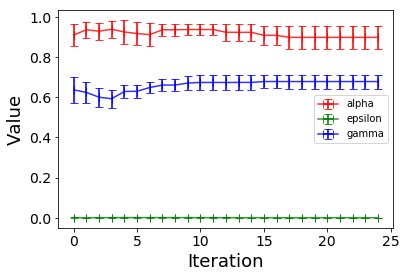

In [313]:
def opt_means8(param_name):
    return [np.mean(l) for l in np.array(params_dict[param_name]).T][:opt_runs]
def opt_sems8(param_name):
    return [2*np.std(l, axis=0)/np.sqrt(opt_runs) for l in np.array(params_dict[param_name]).T][:opt_runs]
alpha_plot=plt.errorbar(np.arange(opt_runs), opt_means8('alpha'), opt_sems8('alpha'), 0, elinewidth=2, capsize=4, alpha=0.8, color='r',label='alpha')
epsilon_plot=plt.errorbar(np.arange(opt_runs), opt_means8('epsilon'), opt_sems8('epsilon'), 0, elinewidth=2, capsize=4, alpha=0.8, color='g',label='epsilon')
gamma_plot=plt.errorbar(np.arange(opt_runs), opt_means8('gamma'), opt_sems8('gamma'), 0, elinewidth=2, capsize=4, alpha=0.8, color='b',label='gamma')
plt.legend(handles=[alpha_plot, epsilon_plot, gamma_plot])
plt.xlabel('Iteration',fontsize=fontsize)
plt.ylabel('Value',fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

\overline{\alpha} &= 0.898269 \pm 0.898269\\
\overline{\epsilon} &= 0.000707 \pm 0.000707\\
\overline{\gamma} &= 0.678322 \pm 0.678322\\


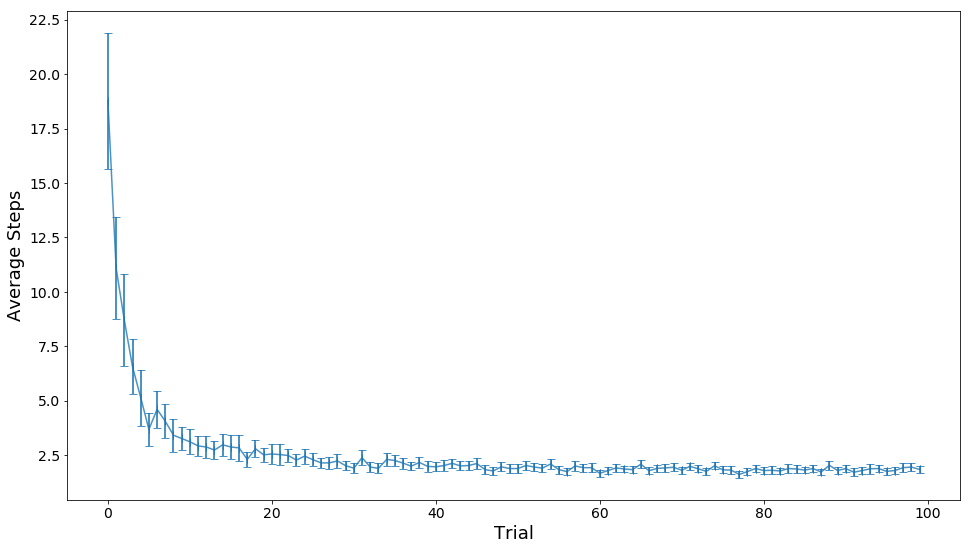

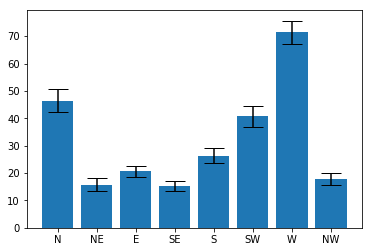

In [328]:
final_params8 = []
for k in params_dict.keys():
    foo_bar = np.round(opt_means8(k)[-1],6)
    foo_sem = np.round(opt_means8(k)[-1],6)
    final_params8 += [foo_bar]
    print("\overline{\\" + k + "}", '&=', str(foo_bar),'\pm',str(foo_sem)+"\\\\")
manyruns(n_trials, *tuple(final_params8),count_actions=True, diagonal=True)

In [282]:
[2][:2]

[2]